# Modelo de recomendación de recetas

### Librerías necesarias

In [46]:
# For data manipulation
import ast
import numpy as np
import pandas as pd

# For data preprocessing
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# For model building
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

# For graph plotting
import matplotlib.pyplot as plt

# For model evaluation
from sklearn.metrics import hamming_loss, classification_report
from sklearn.metrics import jaccard_score
from collections import Counter


In [47]:
recipes = pd.read_csv("data/RAW_recipes.csv")
recipes['ingredients'] = recipes['ingredients'].apply(ast.literal_eval)
recipes.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"[winter squash, mexican seasoning, mixed spice...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"[prepared pizza crust, sausage patty, eggs, mi...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"[ground beef, yellow onions, diced tomatoes, t...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","[spreadable cheese with garlic and herbs, new ...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"[tomato juice, apple cider vinegar, sugar, sal...",8


In [48]:
ingredients = ['apple', 'banana', 'orange', 'tomato', 'carrot', 'bread', 'cheese', 'mango', 'broccoli', 'grape', 'lemmon', 'pineapple']

ingredients_count = {}
for row in recipes['ingredients']:
    for ingredient in row:
        if ingredient in ingredients:
            if ingredient in ingredients_count: ingredients_count[ingredient] += 1
            else: ingredients_count[ingredient] = 1

ingredients_count

{'cheese': 2712,
 'apple': 1604,
 'bread': 1903,
 'carrot': 6707,
 'broccoli': 1508,
 'banana': 2327,
 'mango': 700,
 'pineapple': 756,
 'orange': 999}

In [49]:
len(recipes)

231637

In [50]:
# Filtering recipes that contain at least one of the selected ingredients
recipes = recipes[recipes['ingredients'].apply(lambda x: any([k in x for k in ingredients]))]
len(recipes)

18122

In [51]:
#recipes = recipes[:60000]

In [52]:
# Just leaving ingredients with a max length of 20 characters
max_len = 20
recipes = recipes[recipes['ingredients'].apply(lambda x: all(len(i) <= max_len for i in x))]
len(recipes)

11191

In [53]:
# Removing ingredients that are not in the list
recipes['ingredients'] = recipes['ingredients'].apply(lambda x: [i for i in x if i in ingredients])
len(recipes)

11191

In [54]:
# Applying MultiLabelBinarizer to the ingredients column
mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(recipes['ingredients'])
Y

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [55]:
ingredients_list = recipes['ingredients'].explode().unique().tolist()
ingredients_list = [str(ingredient) for ingredient in ingredients_list if pd.notna(ingredient)]
len(ingredients_list)

9

In [56]:
# Tokenizing the ingredients
tokenizer = Tokenizer()
tokenizer.fit_on_texts(ingredients_list)

# Creating a new column with the tokenized ingredients
recipes['ingredients_code'] = tokenizer.texts_to_sequences(recipes['ingredients'])

# Padding the sequences
X = pad_sequences(recipes['ingredients_code'], maxlen=max_len, padding='post')

recipes.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,ingredients_code
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,[cheese],6,[1]
16,chile rellenos,43026,45,52268,2002-10-14,"['60-minutes-or-less', 'time-to-make', 'course...","[94.0, 10.0, 0.0, 11.0, 11.0, 21.0, 0.0]",9,"['drain green chiles', 'sprinkle cornstarch on...",a favorite from a local restaurant no longer i...,[cheese],5,[1]
23,deep fried dessert thingys,107699,20,158966,2005-01-05,"['30-minutes-or-less', 'time-to-make', 'course...","[1663.3, 221.0, 168.0, 66.0, 19.0, 158.0, 29.0]",20,"['in a large bowl , mix flour , granulated sug...",my mother used to make this for us as a specia...,[bread],13,[2]
63,more more apple pear jigglers,63593,125,47858,2003-06-02,"['weeknight', 'time-to-make', 'main-ingredient...","[22.9, 1.0, 5.0, 0.0, 1.0, 3.0, 0.0]",6,"['in a food processor or blender , process the...",it's a fun finger food for infants and toddler...,[apple],6,[3]
66,my muffuletta sandwich,78655,20,12875,2003-12-12,"['30-minutes-or-less', 'time-to-make', 'course...","[181.1, 26.0, 6.0, 17.0, 2.0, 11.0, 2.0]",3,"['mix everything in food processor', 'chop fin...",watched a documentary about the,[carrot],17,[4]


In [57]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state = 314)

vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100
input_length = max_len

model = Sequential()
model.add(Embedding(input_dim = vocab_size , output_dim=embedding_dim, input_length=input_length))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(len(mlb.classes_), activation='sigmoid')) 

model.compile(optimizer='adam', loss='binary_crossentropy')

history = model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_data=(X_val, Y_val))


Epoch 1/10
280/280 [==============================] - 1s 1ms/step - loss: 0.1553 - val_loss: 0.0202
Epoch 2/10
280/280 [==============================] - 0s 1ms/step - loss: 0.0094 - val_loss: 0.0041
Epoch 3/10
280/280 [==============================] - 0s 1ms/step - loss: 0.0030 - val_loss: 0.0019
Epoch 4/10
280/280 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 5/10
280/280 [==============================] - 0s 1ms/step - loss: 7.4307e-04 - val_loss: 7.9086e-04
Epoch 6/10
280/280 [==============================] - 0s 1ms/step - loss: 4.2303e-04 - val_loss: 6.6253e-04
Epoch 7/10
280/280 [==============================] - 0s 1ms/step - loss: 2.4143e-04 - val_loss: 4.8667e-04
Epoch 8/10
280/280 [==============================] - 0s 1ms/step - loss: 1.5535e-04 - val_loss: 3.3687e-04
Epoch 9/10
280/280 [==============================] - 0s 1ms/step - loss: 1.0486e-04 - val_loss: 3.0868e-04
Epoch 10/10
280/280 [==============================] - 0s 1m

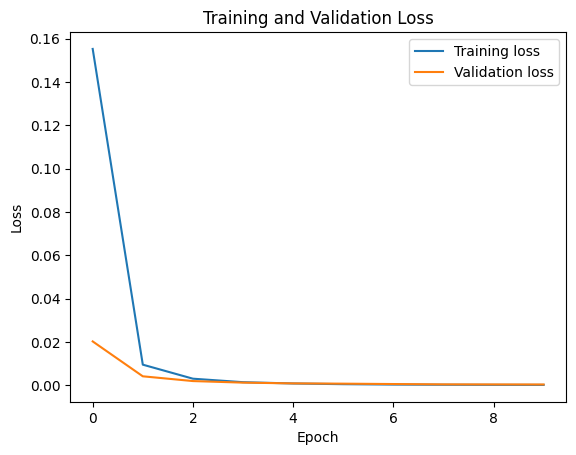

In [58]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [59]:
threshold = 0.5
Y_pred = model.predict(X_val)
Y_pred_binary = (Y_pred >= threshold).astype(int)

# Calculating metrics
print(classification_report(Y_val, Y_pred_binary))


70/70 [==============================] - 0s 864us/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       226
           1       1.00      1.00      1.00       299
           2       1.00      1.00      1.00       299
           3       1.00      1.00      1.00       159
           4       1.00      1.00      1.00       721
           5       1.00      1.00      1.00       350
           6       1.00      1.00      1.00        74
           7       1.00      0.99      1.00       136
           8       1.00      0.99      1.00       112

   micro avg       1.00      1.00      1.00      2376
   macro avg       1.00      1.00      1.00      2376
weighted avg       1.00      1.00      1.00      2376
 samples avg       1.00      1.00      1.00      2376



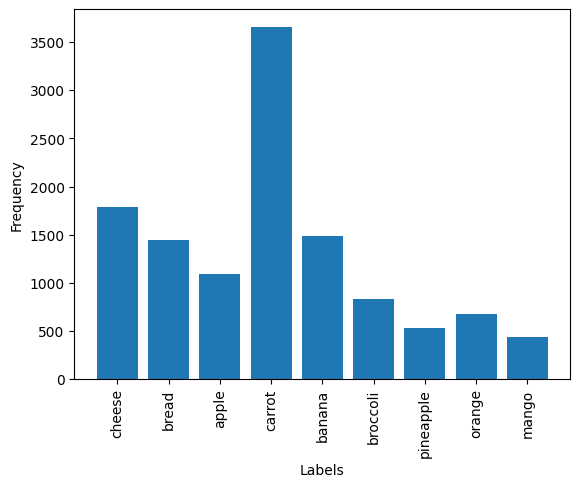

In [60]:
all_labels = [label for sublist in recipes['ingredients'] for label in sublist]
label_counts = Counter(all_labels)
labels, counts = zip(*label_counts.items())

plt.bar(labels, counts)
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()


In [61]:
counts_vals = np.array(list(label_counts.values()))

mean = np.mean(counts_vals)
std_dev = np.std(counts_vals)
coef_var = std_dev / mean

print(f"Mean: {mean}")
print(f"Standard deviation: {std_dev}")
print(f"Coefficient of variation: {coef_var}")


Mean: 1327.6666666666667
Standard deviation: 933.2198740561269
Coefficient of variation: 0.7029022400623601


In [62]:
threshold = 25
rare_labels = [label for label, count in label_counts.items() if count < threshold]

print(f"Rare labels: {rare_labels}")
len(rare_labels)

Rare labels: []


0

In [63]:
mock_data_set = {
    'recipe_id': [1, 2, 3, 4, 5],
    'recipe_name': ['R1', 'R2', 'R3', 'R4', 'R5'],
    'ingredients': [
        ['apple', 'banana', 'orange'],
        ['tomato', 'carrot', 'bread'],
        ['cheese', 'broccoli'],
        ['grape', 'lemmon', 'pineapple', 'apple'],
        ['apple', 'banana', 'orange', 'pineapple', 'mango']
    ]
}

mock_df = pd.DataFrame(mock_data_set)
mock_df.head()

,recipe_id,recipe_name,ingredients
0,1,R1,"[apple, banana, orange]"
1,2,R2,"[tomato, carrot, bread]"
2,3,R3,"[cheese, broccoli]"
3,4,R4,"[grape, lemmon, pineapple, apple]"
4,5,R5,"[apple, banana, orange, pineapple, mango]"


In [64]:
mock_df['ingredients_code'] = tokenizer.texts_to_sequences(mock_df['ingredients'])
X_new = pad_sequences(mock_df['ingredients_code'], maxlen=max_len, padding='post')

predictions = model.predict(X_new)
predictions = predictions * 100
predictions

1/1 [==============================] - 0s 11ms/step


array([[9.99998703e+01, 9.99940491e+01, 8.33984115e-04, 3.47626446e-05,
        3.13659105e-03, 3.85633757e-05, 1.38079925e-02, 2.33681908e+01,
        7.12878704e-02],
       [4.00217308e-04, 4.58279188e-04, 9.98681793e+01, 9.16324730e-04,
        9.99949722e+01, 1.02596255e-02, 6.94573671e-03, 9.32769384e-03,
        2.06404638e-06],
       [1.17677992e-05, 1.36105900e-05, 1.49705983e-03, 9.99732437e+01,
        5.10453954e-02, 9.99999008e+01, 6.88440902e-11, 4.96683086e-08,
        3.25554004e-03],
       [9.95602875e+01, 5.95869496e-02, 9.28913746e-09, 2.75186226e-02,
        1.77426875e-01, 2.41395429e-01, 1.99166359e-04, 6.70527061e-03,
        9.99907761e+01],
       [9.99996338e+01, 9.99953308e+01, 2.90215202e-03, 4.10890425e-05,
        2.23905984e-02, 1.30856977e-04, 3.13544214e-01, 8.34267349e+01,
        6.14669418e+00]], dtype=float32)

In [65]:
input_ingredients = ['apple', 'banana', 'orange']
input_tokens = [tokenizer.word_index[ingredient] for ingredient in input_ingredients if ingredient in tokenizer.word_index]
input_padded = pad_sequences([input_tokens], maxlen=max_len, padding='post')
input_padded

predictions = model.predict(input_padded)
predictions = predictions * 100
predictions

1/1 [==============================] - 0s 11ms/step


array([[9.99998703e+01, 9.99940491e+01, 8.33983358e-04, 3.47626774e-05,
        3.13659105e-03, 3.85634121e-05, 1.38080185e-02, 2.33681850e+01,
        7.12878332e-02]], dtype=float32)

In [66]:
input_ingredients = ['apple', 'banana']
input_tokens = [tokenizer.word_index[ingredient] for ingredient in input_ingredients if ingredient in tokenizer.word_index]
input_padded = pad_sequences([input_tokens], maxlen=max_len, padding='post')
input_padded

predictions = model.predict(input_padded)
predictions = predictions * 100
predictions

1/1 [==============================] - 0s 14ms/step


array([[9.9999855e+01, 9.9935188e+01, 4.5140879e-04, 3.6612961e-05,
        1.6067998e-02, 2.4930213e-03, 1.6901793e-04, 2.8002618e-02,
        5.3250082e-03]], dtype=float32)

1 - chili peppers - mexicana
  - ingrediente 1 -  0.55
  - ingrediente 2 - 0.78

2 - pizza hawwaiana - us
  - ingrediente 1 - 0.77
  - ingrediente 3 - 0.88
  - ingrediente 2 - 0.93

pizza hawainna 
